In [25]:
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation, BeitConfig
from transformers import TrainingArguments, Trainer
from datasets import load_metric

from pathlib import Path, PurePosixPath, PureWindowsPath
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import evaluate

from PIL import Image
import numpy as np

import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import time
import os
import cv2
import json

IMG_HEIGHT = 224
IMG_WIDTH = 224


In [26]:
# load image + ground truth map

path = 'headsegmentation_dataset_ccncsa/training.xml'
image_folder = 'headsegmentation_dataset_ccncsa'

def create_dataset(path, image_folder):
    mytree = ET.parse(path)
    myroot = mytree.getroot()
    img_data_array=[]
    class_name=[]
    data_size = 100
    for child in myroot:
        try:
            file_name = PureWindowsPath(child.attrib["name"])
            #file_name = PurePosixPath(file_name)
            image_path = image_folder /file_name
            image = cv2.imread(str(image_path), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            image = np.array(image)
            seg_map = np.zeros((IMG_HEIGHT, IMG_WIDTH))
            if child.tag == 'srcimg':
                img_data_array.append(image)
            elif child.tag == 'labelimg':    
                for i in range(IMG_HEIGHT):
                    for j in range(IMG_WIDTH):
                        if np.array_equal(image[i,j],[0,0,0]):
                            seg_map[i,j] = 0
                        elif np.array_equal(image[i,j],[255,0,0]):
                            seg_map[i,j] = 1
                        elif np.array_equal(image[i,j],[0,255,0]):
                            seg_map[i,j] = 2
                        elif np.array_equal(image[i,j],[0,0,255]):
                            seg_map[i,j] = 3
                        elif np.array_equal(image[i,j],[128,128,128]):
                            seg_map[i,j] = 4
                        elif np.array_equal(image[i,j],[255,255,0]):
                            seg_map[i,j] = 5
                        elif np.array_equal(image[i,j],[255,0,255]):
                            seg_map[i,j] = 6
                        elif np.array_equal(image[i,j],[0,255,255]):
                            seg_map[i,j] = 7
                        elif np.array_equal(image[i,j],[255,255,255]):
                            seg_map[i,j] = 8
                        elif np.array_equal(image[i,j],[255,192,192]):
                            seg_map[i,j] = 9
                        elif np.array_equal(image[i,j],[0,128,128]):
                            seg_map[i,j] = 10                
                class_name.append(seg_map)
        except KeyError:
            pass
        if len(class_name) == data_size:
            break
            
    return img_data_array, class_name

X, y = create_dataset(path, image_folder)
print(len(X))
print(len(y))




100
100


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [4. 4. 4. ... 0. 0. 0.]
 [4. 4. 4. ... 0. 0. 0.]
 [4. 4. 4. ... 0. 0. 0.]]


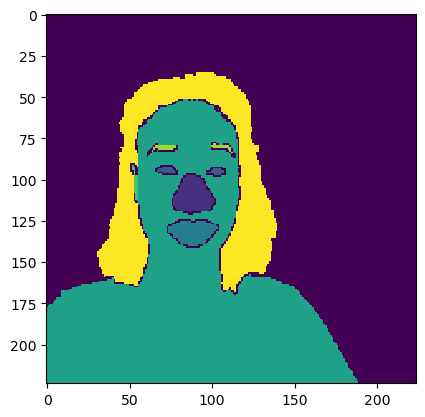

In [27]:
plt.imshow(y[0], interpolation='nearest')
print(y[0])
plt.show()


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)
model_name = "microsoft/beit-base-finetuned-ade-640-640"
feature_extractor = BeitFeatureExtractor.from_pretrained(model_name, size=224 )
print(feature_extractor)
class CustomDataset(Dataset):
    def __init__(self, images, labels, feature_extractor):
        self.images = images
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):

        encoded_inputs = self.feature_extractor(self.images[idx], self.labels[idx], return_tensors="pt")
        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

    def __len__(self):
        return len(self.labels)

train_set = CustomDataset(X_train, y_train, feature_extractor)
val_set = CustomDataset(X_test, y_test, feature_extractor)

batch_size= 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)



BeitFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": false,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "reduce_labels": false,
  "resample": 3,
  "size": 224
}



In [35]:
encoded_inputs = train_set[0]
encoded_inputs["pixel_values"].shape

torch.Size([3, 224, 224])

In [36]:
encoded_inputs["labels"].shape
     

torch.Size([224, 224])

In [37]:
encoded_inputs["labels"]

tensor([[  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        ...,
        [252, 252, 252,  ..., 252, 252,   0],
        [252, 252, 252,  ..., 252, 252, 252],
        [252, 252, 252,  ..., 252, 252, 252]])

In [38]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [39]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [46]:

model_name = "microsoft/beit-base-finetuned-ade-640-640"
filename = "id2label.json"
id2label = json.load(open("id2label.json", "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
config = BeitConfig.from_pretrained(model_name)
config.id2label = id2label
config.label2id = label2id
config.num_labels = 11
config.image_size = 224
config.patch_size = 16
model = BeitForSemanticSegmentation.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)

#print(feature_extractor)
print(model)
#print(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of BeitForSemanticSegmentation were not initialized from the model checkpoint at microsoft/beit-base-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- beit.encoder.layer.0.attention.attention.relative_position_bias.relative_position_bias_table: found shape torch.Size([6244, 12]) in the checkpoint and torch.Size([732, 12]) in the model instantiated
- beit.encoder.layer.0.attention.attention.relative_position_bias.relative_position_index: found shape torch.Size([1601, 1601]) in the checkpoint and torch.Size([197, 197]) in the model instantiated
- beit.encoder.layer.1.attention.attention.relative_position_bias.relative_position_bias_table: found shape torch.Size([6244, 12]) in the checkpoint and torch.Size([732, 12]) in the model instantiated
- beit.encoder.layer.1.attention.attention.relative_position_bias.relative_position_index: found shape torch.Size([1601, 1601]) in the checkpoint and torch.Size([197, 197]) in the model instantiated
- be

BeitForSemanticSegmentation(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (in

In [48]:
max_lr = 1e-3
epochs = 15
weight_decay = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                            steps_per_epoch=len(train_loader))
torch.cuda.empty_cache()
train_losses = []
test_losses = []
val_iou = []; val_acc = []
train_iou = []; train_acc = []
lrs = []
min_loss = np.inf
decrease = 1 ; not_improve=0

model.to(device)
fit_time = time.time()
for e in range(epochs):
    since = time.time()
    running_loss = 0
    iou_score = 0
    accuracy = 0
    #training loop
    model.train()
    for idx, data in enumerate(tqdm(train_loader)):
        #training phase
        pixel_values = data["pixel_values"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        #forward
        output = model(pixel_values, labels=labels)
        loss, logits = output.loss, output.logits
        #backward
        loss.backward()
        optimizer.step() #update weight          
        optimizer.zero_grad() #reset gradient
        
        #step the learning rate
        lrs.append(get_lr(optimizer))
        sched.step() 
        
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            
            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

            # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
            metrics = metric._compute(num_labels=len(id2label), 
                                    ignore_index=255,
                                    reduce_labels=False, # we've already reduced the labels before)
            )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
                                    

  0%|          | 0/70 [00:00<?, ?it/s]

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 768, 1, 1])